In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import d3rlpy
import torch
import numpy as np
from matplotlib import pyplot as plt
from makeSeaquestdata import load_seaquest_dataset, make_seaquest_testset
from load_model import load_seaquest_model
from model import make_episodes, fit_discrete_sac, fit_per_cluster
from utils import create_trajectories, get_trajectory_embedding, perform_clustering_and_plot, trajectory_attributions_sq, set_seeds, print_results_sq
from encoder import CustomCNNFactory

c:\Users\jortv\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Set device and random seed
device = set_seeds(seed=0)

# Set data and test sizes
data_size, test_size = 200, 50

In [5]:
# Load Seaquest dataset
seaquestdata, sq_env = load_seaquest_dataset(env_name='Qbert', size=data_size+test_size)
print(len(seaquestdata["terminals"]))
print(np.unique(seaquestdata["terminals"], return_counts=True))

decompressing data...
Dataset loaded
864
Dataset extracted with 300348 samples.
Information about the dataset:
Observation shape:  (300348, 4, 84, 84)
Action shape:  (300348,)
Reward shape:  (300348,)
Terminal shape:  (300348,)
Action space:  6
Observation space:  (84, 84)
Number of terminal states is... 249
Environment 'ALE/Qbert-ram-v5' initialized.
300348
(array([0, 1], dtype=uint8), array([300099,    249], dtype=int64))


In [6]:
# Load pre-trained encoders
pre_trained_encoder_seaquest = load_seaquest_model("decision_transformer_atari/checkpoints/Qbert_123.pth", vocab_size=6, block_size=90, timesteps=3901, seed=0)

# Create Seaquest test set
seaquestdata, test_observation_sq = make_seaquest_testset(seaquestdata, data_size, test_size)

In [7]:
# Create trajectories and obtain embeddings for Seaquest data
final_obs_sq, final_act_sq, final_rew_sq, _ = create_trajectories(
    seaquestdata["observations"], seaquestdata["actions"], 
    seaquestdata["rewards"], seaquestdata["terminals"], trajectory_length=30
)
trajectory_embedding_seaquest = get_trajectory_embedding(
    pre_trained_encoder_seaquest, final_obs_sq, final_act_sq, final_rew_sq, 
    is_seaquest=True, device=device
)

Processing sub'trajectories: 100%|██████████| 244406/244406 [00:08<00:00, 27202.48it/s]
c:\Users\jortv\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Processing trajectories:   0%|          | 0/8250 [00:00<?, ?it/s]c:\Users\jortv\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Processing trajectories: 100%|██████████| 8250/8250 [02:17<00:00, 60.11it/s]


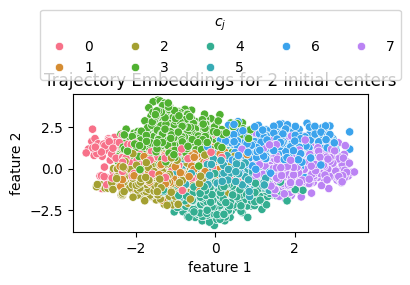

In [8]:
# Perform clustering on Seaquest data
clusters_seaquest, _ = perform_clustering_and_plot(trajectory_embedding_seaquest.detach().cpu().numpy(), 2, 8, ccore=True, plot=True)

In [10]:
 # Train Seaquest model with DiscreteSAC
print('#' * 100)
print("Training Seaquest with DiscreteSAC...")
list_episodes_sq = make_episodes(final_obs_sq, final_act_sq, final_rew_sq, 6)
sac_sq = fit_discrete_sac(list_episodes_sq, n_steps=100, n_steps_per_epoch=10, device=device)

####################################################################################################
Training Seaquest with DiscreteSAC...
2024-04-21 16:30:29 [debug    ] RandomIterator is selected.   
2024-04-21 16:30:29 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240421163029
2024-04-21 16:30:29 [debug    ] Fitting scaler...              scaler=pixel
2024-04-21 16:30:29 [debug    ] Building models...            
2024-04-21 16:30:29 [debug    ] Models have been built.       
2024-04-21 16:30:29 [info     ] Parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163029\params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 0.0001, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'critic_learning_rate': 0.0003, 'cr

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, temp_loss=0.0356, temp=1, critic_loss=2.77, actor_loss=-1.76]


2024-04-21 16:30:32 [info     ] DiscreteSAC_20240421163029: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.0056863069534301754, 'time_algorithm_update': 0.24838130474090575, 'temp_loss': 0.03540037125349045, 'temp': 0.9983565807342529, 'critic_loss': 2.417747211456299, 'actor_loss': -1.8873141288757325, 'time_step': 0.2543725252151489} step=10
2024-04-21 16:30:32 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163029\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s, temp_loss=0.0343, temp=0.997, critic_loss=1.5, actor_loss=-2.34]


2024-04-21 16:30:35 [info     ] DiscreteSAC_20240421163029: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.005763459205627442, 'time_algorithm_update': 0.2435750722885132, 'temp_loss': 0.013311384059488774, 'temp': 0.9954792439937592, 'critic_loss': 0.7891136825084686, 'actor_loss': -3.0883304595947267, 'time_step': 0.24943950176239013} step=20
2024-04-21 16:30:35 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163029\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s, temp_loss=-.0121, temp=0.994, critic_loss=0.402, actor_loss=-3.04]


2024-04-21 16:30:37 [info     ] DiscreteSAC_20240421163029: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.005995798110961914, 'time_algorithm_update': 0.2465963363647461, 'temp_loss': 0.01681971098296344, 'temp': 0.9937973141670227, 'critic_loss': 0.35620071589946745, 'actor_loss': -3.2757981538772585, 'time_step': 0.25284371376037595} step=30
2024-04-21 16:30:37 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163029\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, temp_loss=0.0335, temp=0.993, critic_loss=0.395, actor_loss=-3.65]


2024-04-21 16:30:40 [info     ] DiscreteSAC_20240421163029: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.006192922592163086, 'time_algorithm_update': 0.2487952947616577, 'temp_loss': 0.034560952335596085, 'temp': 0.9917218387126923, 'critic_loss': 0.2998805299401283, 'actor_loss': -3.4209052085876466, 'time_step': 0.25513885021209715} step=40
2024-04-21 16:30:40 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163029\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, temp_loss=0.035, temp=0.99, critic_loss=0.331, actor_loss=-3.43]


2024-04-21 16:30:42 [info     ] DiscreteSAC_20240421163029: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.006134247779846192, 'time_algorithm_update': 0.24713170528411865, 'temp_loss': 0.035007843747735023, 'temp': 0.9888022482395172, 'critic_loss': 0.2791182577610016, 'actor_loss': -3.517192029953003, 'time_step': 0.2534672021865845} step=50
2024-04-21 16:30:42 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163029\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s, temp_loss=0.035, temp=0.987, critic_loss=0.272, actor_loss=-3.44]


2024-04-21 16:30:45 [info     ] DiscreteSAC_20240421163029: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.006760358810424805, 'time_algorithm_update': 0.26322212219238283, 'temp_loss': 0.03492857962846756, 'temp': 0.9856458604335785, 'critic_loss': 0.25189103484153746, 'actor_loss': -3.5014310598373415, 'time_step': 0.2700855016708374} step=60
2024-04-21 16:30:45 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163029\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s, temp_loss=0.0349, temp=0.984, critic_loss=0.337, actor_loss=-3.52]


2024-04-21 16:30:48 [info     ] DiscreteSAC_20240421163029: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.007191109657287598, 'time_algorithm_update': 0.26460421085357666, 'temp_loss': 0.03486311212182045, 'temp': 0.9824576377868652, 'critic_loss': 0.2501199677586555, 'actor_loss': -3.5075782537460327, 'time_step': 0.27199678421020507} step=70
2024-04-21 16:30:48 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163029\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s, temp_loss=0.0348, temp=0.981, critic_loss=0.222, actor_loss=-3.56]


2024-04-21 16:30:51 [info     ] DiscreteSAC_20240421163029: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.006647849082946777, 'time_algorithm_update': 0.25975871086120605, 'temp_loss': 0.03482936359941959, 'temp': 0.9792933881282806, 'critic_loss': 0.23952260464429856, 'actor_loss': -3.5278131484985353, 'time_step': 0.26671562194824217} step=80
2024-04-21 16:30:51 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163029\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, temp_loss=0.0348, temp=0.978, critic_loss=0.28, actor_loss=-3.52]


2024-04-21 16:30:53 [info     ] DiscreteSAC_20240421163029: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.006084275245666504, 'time_algorithm_update': 0.2474308967590332, 'temp_loss': 0.034780151396989825, 'temp': 0.9761643230915069, 'critic_loss': 0.23770393580198287, 'actor_loss': -3.503190755844116, 'time_step': 0.2536167144775391} step=90
2024-04-21 16:30:53 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163029\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, temp_loss=0.0347, temp=0.974, critic_loss=0.21, actor_loss=-3.55]


2024-04-21 16:30:56 [info     ] DiscreteSAC_20240421163029: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.006564211845397949, 'time_algorithm_update': 0.24718751907348632, 'temp_loss': 0.03471374325454235, 'temp': 0.9730706334114074, 'critic_loss': 0.22221651971340178, 'actor_loss': -3.5025450706481935, 'time_step': 0.25400443077087403} step=100
2024-04-21 16:30:56 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163029\model_100.pt


In [11]:
# Compute all possible permutations of clusters
print('#' * 100)
print("Compute all possible permutations of clusters")
feature_size = 128
custom_encoder_actor = CustomCNNFactory(feature_size)
custom_encoder_critic = CustomCNNFactory(feature_size)

model_params_sq = {
    'actor_learning_rate': 3e-4,
    'critic_learning_rate': 3e-4,
    'temp_learning_rate': 3e-4,
    'batch_size': 256,
    'actor_encoder_factory': custom_encoder_actor,
    'critic_encoder_factory': custom_encoder_critic,
    'scaler': 'pixel',
    'use_gpu': True if device == 'cuda' else False
}

####################################################################################################
Compute all possible permutations of clusters


In [12]:
# Fit models per cluster for Seaquest data
models_sq, result_data_combinations_sq = fit_per_cluster(
    model=sac_sq, 
    model_class=d3rlpy.algos.DiscreteSAC,
    model_params=model_params_sq,
    data_embedding=trajectory_embedding_seaquest,
    list_episodes=list_episodes_sq,
    clusters=clusters_seaquest,
    trajectory_embedding=trajectory_embedding_seaquest,
    test_observations=test_observation_sq
)

Original model action:  [0]
Original model action value:  [1.6777823]
Passing:  0 1.6777823
Original model action:  [0]
Original model action value:  [1.6749233]
Passing:  0 1.6749233
Original model action:  [0]
Original model action value:  [1.6693003]
Passing:  0 1.6693003
Original model action:  [0]
Original model action value:  [1.671438]
Passing:  0 1.671438
Original model action:  [0]
Original model action value:  [1.6710613]
Passing:  0 1.6710613
Original model action:  [0]
Original model action value:  [1.6674404]
Passing:  0 1.6674404
Original model action:  [0]
Original model action value:  [1.6767858]
Passing:  0 1.6767858
Original model action:  [0]
Original model action value:  [1.6788392]
Passing:  0 1.6788392
Original model action:  [0]
Original model action value:  [1.6777823]
Passing:  0 1.6777823
Original model action:  [0]
Original model action value:  [1.671088]
Passing:  0 1.671088
Original model action:  [0]
Original model action value:  [1.6756244]
Passing:  0 1.

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s, temp_loss=0.034, temp=1, critic_loss=2.68, actor_loss=-1.81]


2024-04-21 16:30:59 [info     ] DiscreteSAC_20240421163057: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.005728030204772949, 'time_algorithm_update': 0.24659976959228516, 'temp_loss': 0.03510509543120861, 'temp': 0.9983544409275055, 'critic_loss': 2.4056733369827272, 'actor_loss': -1.9630754947662354, 'time_step': 0.2525805950164795} step=10
2024-04-21 16:30:59 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163057\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s, temp_loss=0.0355, temp=0.997, critic_loss=1.69, actor_loss=-2.48]


2024-04-21 16:31:02 [info     ] DiscreteSAC_20240421163057: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.006371140480041504, 'time_algorithm_update': 0.24562833309173585, 'temp_loss': 0.03427931033074856, 'temp': 0.9953659296035766, 'critic_loss': 0.722048419713974, 'actor_loss': -3.517809247970581, 'time_step': 0.252214241027832} step=20
2024-04-21 16:31:02 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163057\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s, temp_loss=0.0328, temp=0.994, critic_loss=0.251, actor_loss=-3.25]


2024-04-21 16:31:05 [info     ] DiscreteSAC_20240421163057: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.006150007247924805, 'time_algorithm_update': 0.24477651119232177, 'temp_loss': 0.03402235172688961, 'temp': 0.992420357465744, 'critic_loss': 0.3249614804983139, 'actor_loss': -3.2594871282577516, 'time_step': 0.25102853775024414} step=30
2024-04-21 16:31:05 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163057\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, temp_loss=0.0343, temp=0.991, critic_loss=0.261, actor_loss=-3.75]


2024-04-21 16:31:07 [info     ] DiscreteSAC_20240421163057: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.007021331787109375, 'time_algorithm_update': 0.2462003469467163, 'temp_loss': 0.03412072993814945, 'temp': 0.9894827723503112, 'critic_loss': 0.2725489675998688, 'actor_loss': -3.583121490478516, 'time_step': 0.2532730340957642} step=40
2024-04-21 16:31:07 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163057\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s, temp_loss=0.0341, temp=0.988, critic_loss=0.24, actor_loss=-3.32]


2024-04-21 16:31:10 [info     ] DiscreteSAC_20240421163057: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.006121015548706055, 'time_algorithm_update': 0.2456763744354248, 'temp_loss': 0.0341066837310791, 'temp': 0.9865488231182098, 'critic_loss': 0.22303920835256577, 'actor_loss': -3.489457845687866, 'time_step': 0.2519012689590454} step=50
2024-04-21 16:31:10 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163057\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s, temp_loss=0.0342, temp=0.985, critic_loss=0.172, actor_loss=-3.6]


2024-04-21 16:31:12 [info     ] DiscreteSAC_20240421163057: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.0061735868453979496, 'time_algorithm_update': 0.24425997734069824, 'temp_loss': 0.03419637903571129, 'temp': 0.9836192846298217, 'critic_loss': 0.21187663972377777, 'actor_loss': -3.504854369163513, 'time_step': 0.25053536891937256} step=60
2024-04-21 16:31:12 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163057\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s, temp_loss=0.0342, temp=0.982, critic_loss=0.265, actor_loss=-3.5]


2024-04-21 16:31:15 [info     ] DiscreteSAC_20240421163057: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.006515955924987793, 'time_algorithm_update': 0.24317381381988526, 'temp_loss': 0.03422077670693398, 'temp': 0.9806928038597107, 'critic_loss': 0.21687397360801697, 'actor_loss': -3.536037826538086, 'time_step': 0.24989149570465088} step=70
2024-04-21 16:31:15 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163057\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s, temp_loss=0.0343, temp=0.979, critic_loss=0.202, actor_loss=-3.51]


2024-04-21 16:31:17 [info     ] DiscreteSAC_20240421163057: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.006032347679138184, 'time_algorithm_update': 0.24551384449005126, 'temp_loss': 0.034382423385977745, 'temp': 0.9777698159217835, 'critic_loss': 0.18968731313943862, 'actor_loss': -3.5267842769622804, 'time_step': 0.25164744853973386} step=80
2024-04-21 16:31:17 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163057\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s, temp_loss=0.0345, temp=0.976, critic_loss=0.245, actor_loss=-3.54]


2024-04-21 16:31:20 [info     ] DiscreteSAC_20240421163057: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.006334280967712403, 'time_algorithm_update': 0.24414560794830323, 'temp_loss': 0.034541505575180056, 'temp': 0.9748459398746491, 'critic_loss': 0.21521964222192763, 'actor_loss': -3.506246566772461, 'time_step': 0.2505807638168335} step=90
2024-04-21 16:31:20 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163057\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, temp_loss=0.0346, temp=0.973, critic_loss=0.208, actor_loss=-3.48]


2024-04-21 16:31:23 [info     ] DiscreteSAC_20240421163057: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.006163859367370605, 'time_algorithm_update': 0.2472069263458252, 'temp_loss': 0.03454260677099228, 'temp': 0.9719225466251373, 'critic_loss': 0.20733887255191802, 'actor_loss': -3.5127392053604125, 'time_step': 0.25347676277160647} step=100
2024-04-21 16:31:23 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163057\model_100.pt
New model action:  [0]
New model action value:  [1.6440175]
Passing:  0 1.6440175
New model action:  [0]
New model action value:  [1.6453552]
Passing:  0 1.6453552
New model action:  [0]
New model action value:  [1.6432099]
Passing:  0 1.6432099
New model action:  [0]
New model action value:  [1.6424181]
Passing:  0 1.6424181
New model action:  [0]
New model action value:  [1.6420708]
Passing:  0 1.6420708
New model action:  [0]
New model action value:  [1.6384008]
Passing:  0 1.6384008
New model action:  [0]
New model a

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s, temp_loss=0.0345, temp=1, critic_loss=2.78, actor_loss=-1.77]


2024-04-21 16:31:26 [info     ] DiscreteSAC_20240421163123: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.006408572196960449, 'time_algorithm_update': 0.2716646909713745, 'temp_loss': 0.03508920036256313, 'temp': 0.9983552813529968, 'critic_loss': 2.455375075340271, 'actor_loss': -1.8861895680427552, 'time_step': 0.2781753301620483} step=10
2024-04-21 16:31:26 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163123\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s, temp_loss=0.0347, temp=0.997, critic_loss=1.49, actor_loss=-2.18]


2024-04-21 16:31:29 [info     ] DiscreteSAC_20240421163123: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.006547713279724121, 'time_algorithm_update': 0.26832146644592286, 'temp_loss': 0.021474187343847005, 'temp': 0.9954239189624786, 'critic_loss': 0.803917545080185, 'actor_loss': -2.9784306287765503, 'time_step': 0.2750722408294678} step=20
2024-04-21 16:31:29 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163123\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s, temp_loss=0.00828, temp=0.994, critic_loss=0.446, actor_loss=-3.06]


2024-04-21 16:31:32 [info     ] DiscreteSAC_20240421163123: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.006150746345520019, 'time_algorithm_update': 0.260880708694458, 'temp_loss': 0.025182333216071127, 'temp': 0.993063747882843, 'critic_loss': 0.35409244894981384, 'actor_loss': -3.238749051094055, 'time_step': 0.26725828647613525} step=30
2024-04-21 16:31:32 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163123\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s, temp_loss=0.0343, temp=0.992, critic_loss=0.281, actor_loss=-3.65]


2024-04-21 16:31:34 [info     ] DiscreteSAC_20240421163123: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.005731272697448731, 'time_algorithm_update': 0.24510598182678223, 'temp_loss': 0.034990182146430016, 'temp': 0.9904173612594604, 'critic_loss': 0.2857958346605301, 'actor_loss': -3.500501346588135, 'time_step': 0.25093917846679686} step=40
2024-04-21 16:31:34 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163123\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  3.61it/s, temp_loss=0.0352, temp=0.989, critic_loss=0.294, actor_loss=-3.37]


2024-04-21 16:31:37 [info     ] DiscreteSAC_20240421163123: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.006179714202880859, 'time_algorithm_update': 0.2691889047622681, 'temp_loss': 0.03513364568352699, 'temp': 0.987353402376175, 'critic_loss': 0.26495171040296556, 'actor_loss': -3.5160598754882812, 'time_step': 0.27556965351104734} step=50
2024-04-21 16:31:37 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163123\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s, temp_loss=0.035, temp=0.986, critic_loss=0.251, actor_loss=-3.46]


2024-04-21 16:31:40 [info     ] DiscreteSAC_20240421163123: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.006447529792785645, 'time_algorithm_update': 0.267954421043396, 'temp_loss': 0.03492034524679184, 'temp': 0.9841951489448547, 'critic_loss': 0.2506762146949768, 'actor_loss': -3.484815073013306, 'time_step': 0.27450406551361084} step=60
2024-04-21 16:31:40 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163123\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s, temp_loss=0.0349, temp=0.982, critic_loss=0.266, actor_loss=-3.57]


2024-04-21 16:31:43 [info     ] DiscreteSAC_20240421163123: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.006658530235290528, 'time_algorithm_update': 0.27224483489990237, 'temp_loss': 0.03486673422157764, 'temp': 0.9810472369194031, 'critic_loss': 0.2404927432537079, 'actor_loss': -3.5432116746902467, 'time_step': 0.27910699844360354} step=70
2024-04-21 16:31:43 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163123\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s, temp_loss=0.0348, temp=0.979, critic_loss=0.215, actor_loss=-3.54]


2024-04-21 16:31:45 [info     ] DiscreteSAC_20240421163123: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.005782413482666016, 'time_algorithm_update': 0.24448611736297607, 'temp_loss': 0.03474465757608414, 'temp': 0.9779324054718017, 'critic_loss': 0.2380960017442703, 'actor_loss': -3.535934090614319, 'time_step': 0.25036962032318116} step=80
2024-04-21 16:31:45 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163123\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s, temp_loss=0.0347, temp=0.976, critic_loss=0.18, actor_loss=-3.52]


2024-04-21 16:31:48 [info     ] DiscreteSAC_20240421163123: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.005896449089050293, 'time_algorithm_update': 0.24604806900024415, 'temp_loss': 0.03469876646995544, 'temp': 0.9748536288738251, 'critic_loss': 0.23428495824337006, 'actor_loss': -3.505832648277283, 'time_step': 0.2521886110305786} step=90
2024-04-21 16:31:48 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163123\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, temp_loss=0.0346, temp=0.973, critic_loss=0.188, actor_loss=-3.55]


2024-04-21 16:31:50 [info     ] DiscreteSAC_20240421163123: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.005973267555236817, 'time_algorithm_update': 0.2474680185317993, 'temp_loss': 0.034527074173092843, 'temp': 0.9718079268932343, 'critic_loss': 0.22329027205705643, 'actor_loss': -3.5087867736816407, 'time_step': 0.2536940336227417} step=100
2024-04-21 16:31:50 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163123\model_100.pt
New model action:  [0]
New model action value:  [1.7210091]
Passing:  0 1.7210091
New model action:  [0]
New model action value:  [1.7242881]
Passing:  0 1.7242881
New model action:  [0]
New model action value:  [1.7200792]
Passing:  0 1.7200792
New model action:  [0]
New model action value:  [1.7187581]
Passing:  0 1.7187581
New model action:  [0]
New model action value:  [1.7191771]
Passing:  0 1.7191771
New model action:  [0]
New model action value:  [1.7115734]
Passing:  0 1.7115734
New model action:  [0]
New model a

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, temp_loss=0.0345, temp=1, critic_loss=2.56, actor_loss=-1.78]


2024-04-21 16:31:54 [info     ] DiscreteSAC_20240421163151: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00585174560546875, 'time_algorithm_update': 0.2475757360458374, 'temp_loss': 0.03488820381462574, 'temp': 0.9983556687831878, 'critic_loss': 2.284594941139221, 'actor_loss': -2.011278772354126, 'time_step': 0.25352842807769777} step=10
2024-04-21 16:31:54 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163151\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, temp_loss=0.0341, temp=0.997, critic_loss=0.992, actor_loss=-2.83]


2024-04-21 16:31:56 [info     ] DiscreteSAC_20240421163151: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.006067991256713867, 'time_algorithm_update': 0.24871432781219482, 'temp_loss': -0.0025530217913910746, 'temp': 0.9955813348293304, 'critic_loss': 0.704833522439003, 'actor_loss': -3.298886275291443, 'time_step': 0.2548996925354004} step=20
2024-04-21 16:31:56 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163151\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s, temp_loss=-.0358, temp=0.995, critic_loss=0.493, actor_loss=-2.92]


2024-04-21 16:31:59 [info     ] DiscreteSAC_20240421163151: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.005835843086242676, 'time_algorithm_update': 0.24426963329315185, 'temp_loss': 0.009424130711704493, 'temp': 0.9950266897678375, 'critic_loss': 0.3985437095165253, 'actor_loss': -3.269346594810486, 'time_step': 0.2503073215484619} step=30
2024-04-21 16:31:59 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163151\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s, temp_loss=0.0315, temp=0.995, critic_loss=0.274, actor_loss=-3.6]


2024-04-21 16:32:01 [info     ] DiscreteSAC_20240421163151: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.00590665340423584, 'time_algorithm_update': 0.24603540897369386, 'temp_loss': 0.033381184190511705, 'temp': 0.9939477622509003, 'critic_loss': 0.2871820002794266, 'actor_loss': -3.454500603675842, 'time_step': 0.25214290618896484} step=40
2024-04-21 16:32:01 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163151\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s, temp_loss=0.0344, temp=0.993, critic_loss=0.29, actor_loss=-3.42]


2024-04-21 16:32:04 [info     ] DiscreteSAC_20240421163151: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.006029844284057617, 'time_algorithm_update': 0.24665303230285646, 'temp_loss': 0.03455479554831982, 'temp': 0.9915461122989655, 'critic_loss': 0.2591015636920929, 'actor_loss': -3.5160818338394164, 'time_step': 0.25278282165527344} step=50
2024-04-21 16:32:04 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163151\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s, temp_loss=0.0347, temp=0.99, critic_loss=0.226, actor_loss=-3.62]


2024-04-21 16:32:07 [info     ] DiscreteSAC_20240421163151: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.005866622924804688, 'time_algorithm_update': 0.24328758716583251, 'temp_loss': 0.0347075454890728, 'temp': 0.9886679291725159, 'critic_loss': 0.24401095360517502, 'actor_loss': -3.5108763217926025, 'time_step': 0.24925529956817627} step=60
2024-04-21 16:32:07 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163151\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, temp_loss=0.0348, temp=0.987, critic_loss=0.188, actor_loss=-3.62]


2024-04-21 16:32:09 [info     ] DiscreteSAC_20240421163151: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.00651707649230957, 'time_algorithm_update': 0.24655487537384033, 'temp_loss': 0.03477099724113941, 'temp': 0.9856465697288513, 'critic_loss': 0.23992573767900466, 'actor_loss': -3.58907310962677, 'time_step': 0.2534029006958008} step=70
2024-04-21 16:32:09 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163151\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s, temp_loss=0.0348, temp=0.984, critic_loss=0.189, actor_loss=-3.52]


2024-04-21 16:32:12 [info     ] DiscreteSAC_20240421163151: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.005818223953247071, 'time_algorithm_update': 0.2445882797241211, 'temp_loss': 0.034767905995249745, 'temp': 0.9825938522815705, 'critic_loss': 0.22436725944280625, 'actor_loss': -3.5681933879852297, 'time_step': 0.2505093812942505} step=80
2024-04-21 16:32:12 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163151\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s, temp_loss=0.0348, temp=0.981, critic_loss=0.245, actor_loss=-3.52]


2024-04-21 16:32:14 [info     ] DiscreteSAC_20240421163151: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.006080007553100586, 'time_algorithm_update': 0.24543728828430175, 'temp_loss': 0.03475482575595379, 'temp': 0.9795474171638489, 'critic_loss': 0.2244922161102295, 'actor_loss': -3.532344627380371, 'time_step': 0.25172502994537355} step=90
2024-04-21 16:32:14 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163151\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s, temp_loss=0.0348, temp=0.978, critic_loss=0.224, actor_loss=-3.57]


2024-04-21 16:32:17 [info     ] DiscreteSAC_20240421163151: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.006436729431152343, 'time_algorithm_update': 0.2644495964050293, 'temp_loss': 0.0347445223480463, 'temp': 0.9765179455280304, 'critic_loss': 0.2187046930193901, 'actor_loss': -3.5510654926300047, 'time_step': 0.27098898887634276} step=100
2024-04-21 16:32:17 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163151\model_100.pt
New model action:  [0]
New model action value:  [1.7600105]
Passing:  0 1.7600105
New model action:  [0]
New model action value:  [1.7637088]
Passing:  0 1.7637088
New model action:  [0]
New model action value:  [1.7588975]
Passing:  0 1.7588975
New model action:  [0]
New model action value:  [1.7592733]
Passing:  0 1.7592733
New model action:  [0]
New model action value:  [1.7598141]
Passing:  0 1.7598141
New model action:  [0]
New model action value:  [1.7557623]
Passing:  0 1.7557623
New model action:  [0]
New model act

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s, temp_loss=0.0349, temp=1, critic_loss=2.69, actor_loss=-1.78]


2024-04-21 16:32:20 [info     ] DiscreteSAC_20240421163218: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.005994486808776856, 'time_algorithm_update': 0.25840296745300295, 'temp_loss': 0.03534142039716244, 'temp': 0.998355507850647, 'critic_loss': 2.387078785896301, 'actor_loss': -2.0017280101776125, 'time_step': 0.2646003246307373} step=10
2024-04-21 16:32:21 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163218\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s, temp_loss=0.0336, temp=0.997, critic_loss=1.12, actor_loss=-2.78]


2024-04-21 16:32:23 [info     ] DiscreteSAC_20240421163218: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.006328177452087402, 'time_algorithm_update': 0.25588836669921877, 'temp_loss': 0.014078316383529455, 'temp': 0.9955431938171386, 'critic_loss': 0.526328656077385, 'actor_loss': -3.5431954860687256, 'time_step': 0.2624790668487549} step=20
2024-04-21 16:32:23 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163218\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, temp_loss=0.0232, temp=0.994, critic_loss=0.409, actor_loss=-3.1]


2024-04-21 16:32:26 [info     ] DiscreteSAC_20240421163218: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.005799126625061035, 'time_algorithm_update': 0.2475867509841919, 'temp_loss': 0.032138793542981145, 'temp': 0.993327397108078, 'critic_loss': 0.3696402430534363, 'actor_loss': -3.3858533620834352, 'time_step': 0.2534860372543335} step=30
2024-04-21 16:32:26 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163218\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s, temp_loss=0.035, temp=0.992, critic_loss=0.323, actor_loss=-3.89]


2024-04-21 16:32:28 [info     ] DiscreteSAC_20240421163218: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.005828952789306641, 'time_algorithm_update': 0.2440650701522827, 'temp_loss': 0.034727056697011, 'temp': 0.9905361294746399, 'critic_loss': 0.2769689276814461, 'actor_loss': -3.536645007133484, 'time_step': 0.24999480247497557} step=40
2024-04-21 16:32:28 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163218\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, temp_loss=0.0345, temp=0.989, critic_loss=0.217, actor_loss=-3.4]


2024-04-21 16:32:31 [info     ] DiscreteSAC_20240421163218: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.006104826927185059, 'time_algorithm_update': 0.255825400352478, 'temp_loss': 0.034522926434874535, 'temp': 0.9874581158161163, 'critic_loss': 0.25657515078783033, 'actor_loss': -3.585120964050293, 'time_step': 0.26218233108520506} step=50
2024-04-21 16:32:31 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163218\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, temp_loss=0.0345, temp=0.986, critic_loss=0.247, actor_loss=-3.51]


2024-04-21 16:32:34 [info     ] DiscreteSAC_20240421163218: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.00596308708190918, 'time_algorithm_update': 0.2514566659927368, 'temp_loss': 0.03450450487434864, 'temp': 0.9843331038951874, 'critic_loss': 0.26297109127044677, 'actor_loss': -3.524021768569946, 'time_step': 0.25752642154693606} step=60
2024-04-21 16:32:34 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163218\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s, temp_loss=0.0344, temp=0.983, critic_loss=0.267, actor_loss=-3.63]


2024-04-21 16:32:36 [info     ] DiscreteSAC_20240421163218: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.0062770843505859375, 'time_algorithm_update': 0.24802637100219727, 'temp_loss': 0.03436016216874123, 'temp': 0.9812226176261902, 'critic_loss': 0.24991959929466248, 'actor_loss': -3.5465612411499023, 'time_step': 0.254404878616333} step=70
2024-04-21 16:32:36 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163218\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s, temp_loss=0.0342, temp=0.98, critic_loss=0.237, actor_loss=-3.53]


2024-04-21 16:32:39 [info     ] DiscreteSAC_20240421163218: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.005922079086303711, 'time_algorithm_update': 0.25677626132965087, 'temp_loss': 0.034183775261044505, 'temp': 0.9781458675861359, 'critic_loss': 0.2377926617860794, 'actor_loss': -3.582960271835327, 'time_step': 0.2629569053649902} step=80
2024-04-21 16:32:39 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163218\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, temp_loss=0.0342, temp=0.976, critic_loss=0.208, actor_loss=-3.56]


2024-04-21 16:32:42 [info     ] DiscreteSAC_20240421163218: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.005784153938293457, 'time_algorithm_update': 0.24932599067687988, 'temp_loss': 0.03412603475153446, 'temp': 0.9751041054725647, 'critic_loss': 0.2316719651222229, 'actor_loss': -3.5142948627471924, 'time_step': 0.25544424057006837} step=90
2024-04-21 16:32:42 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163218\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s, temp_loss=0.034, temp=0.973, critic_loss=0.188, actor_loss=-3.55]


2024-04-21 16:32:44 [info     ] DiscreteSAC_20240421163218: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.005860066413879395, 'time_algorithm_update': 0.2466001033782959, 'temp_loss': 0.033947760611772536, 'temp': 0.972092616558075, 'critic_loss': 0.22768498957157135, 'actor_loss': -3.5539180994033814, 'time_step': 0.2525640964508057} step=100
2024-04-21 16:32:44 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163218\model_100.pt
New model action:  [1]
New model action value:  [1.6838553]
Passing:  1 1.6838553
New model action:  [1]
New model action value:  [1.6888711]
Passing:  1 1.6888711
New model action:  [1]
New model action value:  [1.6813037]
Passing:  1 1.6813037
New model action:  [1]
New model action value:  [1.6822004]
Passing:  1 1.6822004
New model action:  [1]
New model action value:  [1.681745]
Passing:  1 1.681745
New model action:  [1]
New model action value:  [1.6783049]
Passing:  1 1.6783049
New model action:  [1]
New model acti

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s, temp_loss=0.0352, temp=1, critic_loss=2.74, actor_loss=-1.8]


2024-04-21 16:32:47 [info     ] DiscreteSAC_20240421163245: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.005870270729064942, 'time_algorithm_update': 0.2541069984436035, 'temp_loss': 0.03467557914555073, 'temp': 0.9983573019504547, 'critic_loss': 2.471280646324158, 'actor_loss': -1.9531471133232117, 'time_step': 0.2601221799850464} step=10
2024-04-21 16:32:48 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163245\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, temp_loss=0.0337, temp=0.997, critic_loss=1.68, actor_loss=-2.42]


2024-04-21 16:32:50 [info     ] DiscreteSAC_20240421163245: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.005559682846069336, 'time_algorithm_update': 0.2476743459701538, 'temp_loss': 0.017737393779680134, 'temp': 0.9954403400421142, 'critic_loss': 0.8224023342132568, 'actor_loss': -3.3200064659118653, 'time_step': 0.253435754776001} step=20
2024-04-21 16:32:50 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163245\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s, temp_loss=-.0238, temp=0.994, critic_loss=0.272, actor_loss=-3.15]


2024-04-21 16:32:53 [info     ] DiscreteSAC_20240421163245: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.005736660957336426, 'time_algorithm_update': 0.24412744045257567, 'temp_loss': 0.011009910982102156, 'temp': 0.9937147080898285, 'critic_loss': 0.3586361467838287, 'actor_loss': -3.233044719696045, 'time_step': 0.250065279006958} step=30
2024-04-21 16:32:53 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163245\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s, temp_loss=0.0327, temp=0.993, critic_loss=0.333, actor_loss=-3.67]


2024-04-21 16:32:55 [info     ] DiscreteSAC_20240421163245: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.005945873260498047, 'time_algorithm_update': 0.2457824945449829, 'temp_loss': 0.03425990454852581, 'temp': 0.9918328166007996, 'critic_loss': 0.27579186409711837, 'actor_loss': -3.525893759727478, 'time_step': 0.25182912349700926} step=40
2024-04-21 16:32:55 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163245\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s, temp_loss=0.0349, temp=0.99, critic_loss=0.226, actor_loss=-3.39]


2024-04-21 16:32:58 [info     ] DiscreteSAC_20240421163245: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.006227564811706543, 'time_algorithm_update': 0.24547183513641357, 'temp_loss': 0.034977742657065394, 'temp': 0.9889960765838623, 'critic_loss': 0.272054959833622, 'actor_loss': -3.5116315603256227, 'time_step': 0.25180037021636964} step=50
2024-04-21 16:32:58 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163245\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, temp_loss=0.035, temp=0.987, critic_loss=0.299, actor_loss=-3.55]


2024-04-21 16:33:00 [info     ] DiscreteSAC_20240421163245: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.006044507026672363, 'time_algorithm_update': 0.25625712871551515, 'temp_loss': 0.03495102562010288, 'temp': 0.985867303609848, 'critic_loss': 0.2629027396440506, 'actor_loss': -3.530510091781616, 'time_step': 0.2623016357421875} step=60
2024-04-21 16:33:01 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163245\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, temp_loss=0.0349, temp=0.984, critic_loss=0.244, actor_loss=-3.58]


2024-04-21 16:33:03 [info     ] DiscreteSAC_20240421163245: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.005709266662597657, 'time_algorithm_update': 0.2510507822036743, 'temp_loss': 0.03484549559652805, 'temp': 0.9826872110366821, 'critic_loss': 0.2284983590245247, 'actor_loss': -3.576894426345825, 'time_step': 0.2568606615066528} step=70
2024-04-21 16:33:03 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163245\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s, temp_loss=0.0348, temp=0.981, critic_loss=0.266, actor_loss=-3.55]


2024-04-21 16:33:06 [info     ] DiscreteSAC_20240421163245: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.006177353858947754, 'time_algorithm_update': 0.25887465476989746, 'temp_loss': 0.03475372232496739, 'temp': 0.9795265793800354, 'critic_loss': 0.23436189144849778, 'actor_loss': -3.5587459087371824, 'time_step': 0.26515350341796873} step=80
2024-04-21 16:33:06 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163245\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, temp_loss=0.0347, temp=0.978, critic_loss=0.246, actor_loss=-3.55]


2024-04-21 16:33:08 [info     ] DiscreteSAC_20240421163245: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.006171607971191406, 'time_algorithm_update': 0.2560248851776123, 'temp_loss': 0.03467725478112697, 'temp': 0.9764018535614014, 'critic_loss': 0.2333706647157669, 'actor_loss': -3.5519668579101564, 'time_step': 0.2622976779937744} step=90
2024-04-21 16:33:09 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163245\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s, temp_loss=0.0347, temp=0.975, critic_loss=0.25, actor_loss=-3.53]


2024-04-21 16:33:11 [info     ] DiscreteSAC_20240421163245: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.005756211280822754, 'time_algorithm_update': 0.2545971155166626, 'temp_loss': 0.034628478810191154, 'temp': 0.9733129978179932, 'critic_loss': 0.23363737314939498, 'actor_loss': -3.556444525718689, 'time_step': 0.2605534791946411} step=100
2024-04-21 16:33:11 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163245\model_100.pt
New model action:  [1]
New model action value:  [1.7304635]
Passing:  1 1.7304635
New model action:  [1]
New model action value:  [1.7322845]
Passing:  1 1.7322845
New model action:  [1]
New model action value:  [1.7270415]
Passing:  1 1.7270415
New model action:  [1]
New model action value:  [1.7264643]
Passing:  1 1.7264643
New model action:  [1]
New model action value:  [1.7262653]
Passing:  1 1.7262653
New model action:  [1]
New model action value:  [1.7226825]
Passing:  1 1.7226825
New model action:  [1]
New model ac

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s, temp_loss=0.035, temp=1, critic_loss=2.69, actor_loss=-1.77]


2024-04-21 16:33:15 [info     ] DiscreteSAC_20240421163312: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.0056455135345458984, 'time_algorithm_update': 0.2552013397216797, 'temp_loss': 0.03524717465043068, 'temp': 0.9983559072017669, 'critic_loss': 2.4357184410095214, 'actor_loss': -1.9182634711265565, 'time_step': 0.2610862493515015} step=10
2024-04-21 16:33:15 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163312\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s, temp_loss=0.0349, temp=0.997, critic_loss=1.61, actor_loss=-2.38]


2024-04-21 16:33:17 [info     ] DiscreteSAC_20240421163312: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.006455564498901367, 'time_algorithm_update': 0.24606726169586182, 'temp_loss': 0.03164777439087629, 'temp': 0.9953853845596313, 'critic_loss': 0.7970797777175903, 'actor_loss': -3.339013171195984, 'time_step': 0.25272278785705565} step=20
2024-04-21 16:33:17 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163312\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, temp_loss=0.0237, temp=0.994, critic_loss=0.269, actor_loss=-3.13]


2024-04-21 16:33:20 [info     ] DiscreteSAC_20240421163312: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.006568694114685058, 'time_algorithm_update': 0.2506107330322266, 'temp_loss': 0.029239524528384207, 'temp': 0.9925739765167236, 'critic_loss': 0.3979813277721405, 'actor_loss': -3.1982275009155274, 'time_step': 0.25749280452728274} step=30
2024-04-21 16:33:20 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163312\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, temp_loss=0.0346, temp=0.991, critic_loss=0.278, actor_loss=-3.76]


2024-04-21 16:33:22 [info     ] DiscreteSAC_20240421163312: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.006079959869384766, 'time_algorithm_update': 0.25213193893432617, 'temp_loss': 0.03487719818949699, 'temp': 0.9897215485572814, 'critic_loss': 0.2868949308991432, 'actor_loss': -3.553395891189575, 'time_step': 0.25842900276184083} step=40
2024-04-21 16:33:22 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163312\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, temp_loss=0.0348, temp=0.988, critic_loss=0.275, actor_loss=-3.29]


2024-04-21 16:33:25 [info     ] DiscreteSAC_20240421163312: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.0063675642013549805, 'time_algorithm_update': 0.24854714870452882, 'temp_loss': 0.03463821895420551, 'temp': 0.9867190420627594, 'critic_loss': 0.2591239407658577, 'actor_loss': -3.520925998687744, 'time_step': 0.25503129959106446} step=50
2024-04-21 16:33:25 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163312\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, temp_loss=0.0346, temp=0.985, critic_loss=0.253, actor_loss=-3.53]


2024-04-21 16:33:28 [info     ] DiscreteSAC_20240421163312: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.006368613243103028, 'time_algorithm_update': 0.25297672748565675, 'temp_loss': 0.03459966741502285, 'temp': 0.9836902379989624, 'critic_loss': 0.2518715992569923, 'actor_loss': -3.452897238731384, 'time_step': 0.2595529556274414} step=60
2024-04-21 16:33:28 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163312\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s, temp_loss=0.0346, temp=0.982, critic_loss=0.219, actor_loss=-3.58]


2024-04-21 16:33:30 [info     ] DiscreteSAC_20240421163312: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.005925917625427246, 'time_algorithm_update': 0.26136188507080077, 'temp_loss': 0.034635606408119204, 'temp': 0.9806695938110351, 'critic_loss': 0.24579767286777496, 'actor_loss': -3.5655511140823366, 'time_step': 0.2673929691314697} step=70
2024-04-21 16:33:30 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163312\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s, temp_loss=0.0346, temp=0.979, critic_loss=0.222, actor_loss=-3.53]


2024-04-21 16:33:33 [info     ] DiscreteSAC_20240421163312: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.0066195249557495115, 'time_algorithm_update': 0.2562628030776978, 'temp_loss': 0.03468752913177013, 'temp': 0.9776636481285095, 'critic_loss': 0.22335655987262726, 'actor_loss': -3.53687379360199, 'time_step': 0.26318299770355225} step=80
2024-04-21 16:33:33 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163312\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s, temp_loss=0.0347, temp=0.976, critic_loss=0.192, actor_loss=-3.54]


2024-04-21 16:33:36 [info     ] DiscreteSAC_20240421163312: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.005893111228942871, 'time_algorithm_update': 0.24620456695556642, 'temp_loss': 0.03472334630787373, 'temp': 0.9746719419956207, 'critic_loss': 0.25200329422950746, 'actor_loss': -3.5135106086730956, 'time_step': 0.2522977113723755} step=90
2024-04-21 16:33:36 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163312\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s, temp_loss=0.0346, temp=0.973, critic_loss=0.243, actor_loss=-3.57]


2024-04-21 16:33:38 [info     ] DiscreteSAC_20240421163312: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.006428647041320801, 'time_algorithm_update': 0.25320627689361574, 'temp_loss': 0.03437899276614189, 'temp': 0.9716981232166291, 'critic_loss': 0.2436760514974594, 'actor_loss': -3.5036152362823487, 'time_step': 0.25983691215515137} step=100
2024-04-21 16:33:38 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163312\model_100.pt
New model action:  [1]
New model action value:  [1.6438725]
Passing:  1 1.6438725
New model action:  [1]
New model action value:  [1.64404]
Passing:  1 1.64404
New model action:  [1]
New model action value:  [1.6422489]
Passing:  1 1.6422489
New model action:  [1]
New model action value:  [1.6422629]
Passing:  1 1.6422629
New model action:  [1]
New model action value:  [1.6423621]
Passing:  1 1.6423621
New model action:  [1]
New model action value:  [1.6374593]
Passing:  1 1.6374593
New model action:  [1]
New model actio

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, temp_loss=0.0356, temp=1, critic_loss=2.61, actor_loss=-1.77]


2024-04-21 16:33:42 [info     ] DiscreteSAC_20240421163339: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.0063173770904541016, 'time_algorithm_update': 0.25893654823303225, 'temp_loss': 0.035535861551761624, 'temp': 0.9983564436435699, 'critic_loss': 2.344315755367279, 'actor_loss': -1.9189260721206665, 'time_step': 0.2653576612472534} step=10
2024-04-21 16:33:42 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163339\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, temp_loss=0.0354, temp=0.997, critic_loss=1.43, actor_loss=-2.43]


2024-04-21 16:33:44 [info     ] DiscreteSAC_20240421163339: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.0062279939651489254, 'time_algorithm_update': 0.24869863986968993, 'temp_loss': 0.024524748791009188, 'temp': 0.9954109609127044, 'critic_loss': 0.7203978449106216, 'actor_loss': -3.2652541160583497, 'time_step': 0.25513463020324706} step=20
2024-04-21 16:33:44 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163339\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, temp_loss=0.0102, temp=0.994, critic_loss=0.298, actor_loss=-3.09]


2024-04-21 16:33:47 [info     ] DiscreteSAC_20240421163339: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.00611410140991211, 'time_algorithm_update': 0.24777812957763673, 'temp_loss': 0.0253351972438395, 'temp': 0.9929392576217652, 'critic_loss': 0.34880177974700927, 'actor_loss': -3.2883958339691164, 'time_step': 0.254111123085022} step=30
2024-04-21 16:33:47 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163339\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, temp_loss=0.0336, temp=0.992, critic_loss=0.33, actor_loss=-3.82]


2024-04-21 16:33:50 [info     ] DiscreteSAC_20240421163339: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.0060744047164916996, 'time_algorithm_update': 0.24702606201171876, 'temp_loss': 0.03458526134490967, 'temp': 0.9902769446372985, 'critic_loss': 0.29271020740270615, 'actor_loss': -3.5087237119674684, 'time_step': 0.25320351123809814} step=40
2024-04-21 16:33:50 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163339\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, temp_loss=0.0351, temp=0.989, critic_loss=0.22, actor_loss=-3.36]


2024-04-21 16:33:52 [info     ] DiscreteSAC_20240421163339: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.006120610237121582, 'time_algorithm_update': 0.24944677352905273, 'temp_loss': 0.03509594239294529, 'temp': 0.9872486054897308, 'critic_loss': 0.2605713754892349, 'actor_loss': -3.545375847816467, 'time_step': 0.25576736927032473} step=50
2024-04-21 16:33:52 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163339\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s, temp_loss=0.0351, temp=0.986, critic_loss=0.269, actor_loss=-3.42]


2024-04-21 16:33:55 [info     ] DiscreteSAC_20240421163339: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.006671738624572754, 'time_algorithm_update': 0.24756264686584473, 'temp_loss': 0.03502353057265282, 'temp': 0.9841204702854156, 'critic_loss': 0.23974251449108125, 'actor_loss': -3.47090425491333, 'time_step': 0.25434050559997556} step=60
2024-04-21 16:33:55 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163339\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, temp_loss=0.035, temp=0.982, critic_loss=0.313, actor_loss=-3.6]


2024-04-21 16:33:57 [info     ] DiscreteSAC_20240421163339: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.0059336662292480465, 'time_algorithm_update': 0.24723517894744873, 'temp_loss': 0.0349599439650774, 'temp': 0.9809932231903076, 'critic_loss': 0.26891890466213225, 'actor_loss': -3.5104911088943482, 'time_step': 0.253271222114563} step=70
2024-04-21 16:33:57 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163339\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s, temp_loss=0.0349, temp=0.979, critic_loss=0.258, actor_loss=-3.51]


2024-04-21 16:34:00 [info     ] DiscreteSAC_20240421163339: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.006358194351196289, 'time_algorithm_update': 0.24506399631500245, 'temp_loss': 0.03489387109875679, 'temp': 0.9778933882713318, 'critic_loss': 0.24287354201078415, 'actor_loss': -3.514518141746521, 'time_step': 0.251522159576416} step=80
2024-04-21 16:34:00 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163339\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, temp_loss=0.0349, temp=0.976, critic_loss=0.152, actor_loss=-3.56]


2024-04-21 16:34:03 [info     ] DiscreteSAC_20240421163339: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.00642099380493164, 'time_algorithm_update': 0.25135633945465086, 'temp_loss': 0.0348240677267313, 'temp': 0.974825382232666, 'critic_loss': 0.21372974961996077, 'actor_loss': -3.514476442337036, 'time_step': 0.25787887573242185} step=90
2024-04-21 16:34:03 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163339\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, temp_loss=0.0348, temp=0.973, critic_loss=0.206, actor_loss=-3.49]


2024-04-21 16:34:05 [info     ] DiscreteSAC_20240421163339: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.006210494041442871, 'time_algorithm_update': 0.2496159553527832, 'temp_loss': 0.03474300168454647, 'temp': 0.9717879354953766, 'critic_loss': 0.22237124741077424, 'actor_loss': -3.494992399215698, 'time_step': 0.2560293197631836} step=100
2024-04-21 16:34:05 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163339\model_100.pt
New model action:  [5]
New model action value:  [1.6599152]
Passing:  5 1.6599152
New model action:  [5]
New model action value:  [1.6624196]
Passing:  5 1.6624196
New model action:  [5]
New model action value:  [1.6563623]
Passing:  5 1.6563623
New model action:  [5]
New model action value:  [1.6560578]
Passing:  5 1.6560578
New model action:  [5]
New model action value:  [1.6556377]
Passing:  5 1.6556377
New model action:  [5]
New model action value:  [1.6528835]
Passing:  5 1.6528835
New model action:  [5]
New model act

Epoch 1/10: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s, temp_loss=0.0352, temp=1, critic_loss=2.72, actor_loss=-1.8]


2024-04-21 16:34:09 [info     ] DiscreteSAC_20240421163406: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00638277530670166, 'time_algorithm_update': 0.2598896026611328, 'temp_loss': 0.0353604894131422, 'temp': 0.9983560681343079, 'critic_loss': 2.4926232218742372, 'actor_loss': -1.9394827604293823, 'time_step': 0.26637403964996337} step=10
2024-04-21 16:34:09 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163406\model_10.pt


Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s, temp_loss=0.0355, temp=0.997, critic_loss=1.54, actor_loss=-2.39]


2024-04-21 16:34:11 [info     ] DiscreteSAC_20240421163406: epoch=2 step=20 epoch=2 metrics={'time_sample_batch': 0.006808185577392578, 'time_algorithm_update': 0.257833194732666, 'temp_loss': 0.03410084545612335, 'temp': 0.995375519990921, 'critic_loss': 0.7978937983512878, 'actor_loss': -3.2917759656906127, 'time_step': 0.26474263668060305} step=20
2024-04-21 16:34:11 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163406\model_20.pt


Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s, temp_loss=0.0318, temp=0.994, critic_loss=0.339, actor_loss=-3.21]


2024-04-21 16:34:14 [info     ] DiscreteSAC_20240421163406: epoch=3 step=30 epoch=3 metrics={'time_sample_batch': 0.006538987159729004, 'time_algorithm_update': 0.2633980274200439, 'temp_loss': 0.03328415490686894, 'temp': 0.9924509763717652, 'critic_loss': 0.3367534548044205, 'actor_loss': -3.388616609573364, 'time_step': 0.27027528285980223} step=30
2024-04-21 16:34:14 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163406\model_30.pt


Epoch 4/10: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s, temp_loss=0.0345, temp=0.991, critic_loss=0.354, actor_loss=-3.81]


2024-04-21 16:34:17 [info     ] DiscreteSAC_20240421163406: epoch=4 step=40 epoch=4 metrics={'time_sample_batch': 0.006844043731689453, 'time_algorithm_update': 0.28040030002593996, 'temp_loss': 0.03488456904888153, 'temp': 0.9895265698432922, 'critic_loss': 0.29616485685110094, 'actor_loss': -3.563568639755249, 'time_step': 0.2872965335845947} step=40
2024-04-21 16:34:17 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163406\model_40.pt


Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s, temp_loss=0.035, temp=0.988, critic_loss=0.309, actor_loss=-3.47]


2024-04-21 16:34:20 [info     ] DiscreteSAC_20240421163406: epoch=5 step=50 epoch=5 metrics={'time_sample_batch': 0.0068035125732421875, 'time_algorithm_update': 0.27116944789886477, 'temp_loss': 0.03496856987476349, 'temp': 0.9865635812282563, 'critic_loss': 0.2644981160759926, 'actor_loss': -3.61040780544281, 'time_step': 0.2783328056335449} step=50
2024-04-21 16:34:20 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163406\model_50.pt


Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s, temp_loss=0.0349, temp=0.985, critic_loss=0.256, actor_loss=-3.46]


2024-04-21 16:34:22 [info     ] DiscreteSAC_20240421163406: epoch=6 step=60 epoch=6 metrics={'time_sample_batch': 0.005702948570251465, 'time_algorithm_update': 0.2448659896850586, 'temp_loss': 0.034890813380479814, 'temp': 0.9835946083068847, 'critic_loss': 0.23895011246204376, 'actor_loss': -3.5431281089782716, 'time_step': 0.2508726119995117} step=60
2024-04-21 16:34:22 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163406\model_60.pt


Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s, temp_loss=0.0349, temp=0.982, critic_loss=0.235, actor_loss=-3.64]


2024-04-21 16:34:25 [info     ] DiscreteSAC_20240421163406: epoch=7 step=70 epoch=7 metrics={'time_sample_batch': 0.005781030654907227, 'time_algorithm_update': 0.24293985366821289, 'temp_loss': 0.03486012220382691, 'temp': 0.9806349098682403, 'critic_loss': 0.22955259084701538, 'actor_loss': -3.573787569999695, 'time_step': 0.24882204532623292} step=70
2024-04-21 16:34:25 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163406\model_70.pt


Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, temp_loss=0.0348, temp=0.979, critic_loss=0.252, actor_loss=-3.61]


2024-04-21 16:34:28 [info     ] DiscreteSAC_20240421163406: epoch=8 step=80 epoch=8 metrics={'time_sample_batch': 0.006071949005126953, 'time_algorithm_update': 0.24701759815216065, 'temp_loss': 0.034822062402963636, 'temp': 0.9776874661445618, 'critic_loss': 0.23890648335218428, 'actor_loss': -3.5952050924301147, 'time_step': 0.2532983303070068} step=80
2024-04-21 16:34:28 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163406\model_80.pt


Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, temp_loss=0.0348, temp=0.976, critic_loss=0.199, actor_loss=-3.59]


2024-04-21 16:34:30 [info     ] DiscreteSAC_20240421163406: epoch=9 step=90 epoch=9 metrics={'time_sample_batch': 0.006498098373413086, 'time_algorithm_update': 0.25202739238739014, 'temp_loss': 0.03472704812884331, 'temp': 0.9747536063194275, 'critic_loss': 0.228896601498127, 'actor_loss': -3.5671010494232176, 'time_step': 0.25872900485992434} step=90
2024-04-21 16:34:30 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163406\model_90.pt


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, temp_loss=0.0347, temp=0.973, critic_loss=0.156, actor_loss=-3.58]


2024-04-21 16:34:33 [info     ] DiscreteSAC_20240421163406: epoch=10 step=100 epoch=10 metrics={'time_sample_batch': 0.006514430046081543, 'time_algorithm_update': 0.25074067115783694, 'temp_loss': 0.03456403836607933, 'temp': 0.9718357622623444, 'critic_loss': 0.19351761788129807, 'actor_loss': -3.5551620960235595, 'time_step': 0.25745649337768556} step=100
2024-04-21 16:34:33 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240421163406\model_100.pt
New model action:  [1]
New model action value:  [1.6234286]
Passing:  1 1.6234286
New model action:  [1]
New model action value:  [1.6299069]
Passing:  1 1.6299069
New model action:  [1]
New model action value:  [1.6233127]
Passing:  1 1.6233127
New model action:  [1]
New model action value:  [1.6226249]
Passing:  1 1.6226249
New model action:  [1]
New model action value:  [1.622544]
Passing:  1 1.622544
New model action:  [1]
New model action value:  [1.6163595]
Passing:  1 1.6163595
New model action:  [1]
New model ac

In [13]:
attributions_sq = trajectory_attributions_sq(test_observation_sq, models_sq, trajectory_embedding_seaquest, clusters_seaquest)

#################################################################################################### Observation 1 ####################################################################################################
(1, 4, 84, 84)
0-th model predicted action: [0]
Original model's action [0]
1-th model predicted action: [0]
Original model's action [0]
2-th model predicted action: [0]
Original model's action [0]
3-th model predicted action: [0]
Original model's action [0]
4-th model predicted action: [1]
Original model's action [0]
Wasserstein distance:  0.0
5-th model predicted action: [1]
Original model's action [0]
Wasserstein distance:  0.0
6-th model predicted action: [1]
Original model's action [0]
Wasserstein distance:  0.0
7-th model predicted action: [5]
Original model's action [0]
Wasserstein distance:  0.0
8-th model predicted action: [1]
Original model's action [0]
Wasserstein distance:  0.007797755300998688
DEBUG: len(sub_dist) 9
DEBUG: sub_dist [1000000000.0, 1000000000.0, 

In [14]:
# Print table 2 for Seaquest data
print('#' * 100)
print("Print table 2")
print_results_sq(result_data_combinations_sq, test_observation_sq, models_sq, attributions_sq)

####################################################################################################
Print table 2
ivs values
[1.6474376 1.6132364 1.6955653 1.7240651 1.6439726 1.6868708 1.5962754
 1.6121761 1.5708172]
Avg Delta Q
0.0
0.034913758436838783
0.05419646700223287
0.0896325409412384
0.02617906282345454
0.06206215421358744
0.055448358257611595
0.03788985808690389
0.07821650306383769
----------------------------------------------------------------------------------------------------
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
36 0 0
37 0 0
38 0 0
39 0 0
40 0 0
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 

c:\Users\jortv\OneDrive\Bureau\FACT\Explaining-RL-Decisions-with-Trajectories\Breakout\utils.py:464: RuntimeWarning: invalid value encountered in divide
  print(cluster_attr_freq/cluster_attr_freq.sum())


[nan nan nan nan nan nan nan nan nan]
